## Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, round, mean, count, desc, when, to_date, corr, year, month, dayofmonth, dayofweek
from pyspark.sql.types import StringType, BooleanType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("Zillow").getOrCreate()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data Collection


In [ ]:
properties2016 = spark.read.csv("/content/drive/MyDrive/zillow-prize-1/properties_2016.csv", header=True, inferSchema=True)
train2016 = spark.read.csv("/content/drive/MyDrive/zillow-prize-1/train_2016_v2.csv", header=True, inferSchema=True)
properties2017 = spark.read.csv("/content/drive/MyDrive/zillow-prize-1/properties_2017.csv", header=True, inferSchema=True)
train2017 = spark.read.csv("/content/drive/MyDrive/zillow-prize-1/train_2017.csv", header=True, inferSchema=True)

In [ ]:
print(f"properties 2017 has {properties2017.count()} rows and {len(properties2017.columns)} columns")
print(f"properties 2016 has {properties2016.count()} rows and {len(properties2016.columns)} columns")

properties 2017 has 2985217 rows and 58 columns
properties 2016 has 2985217 rows and 58 columns


In [ ]:
properties2016.show(5)

+--------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|airconditioningtypeid|arch

In [ ]:
properties2016.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fireplacecnt: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- gar

In [ ]:
print(f"train 2017  has {train2017.count()} rows and {len(train2017.columns)} columns")
print(f"train 2016 has {train2016.count()} rows and {len(train2016.columns)} columns")

train 2017  has 77613 rows and 3 columns
train 2016 has 90275 rows and 3 columns


In [ ]:
train2016.show(5)

+--------+--------+---------------+
|parcelid|logerror|transactiondate|
+--------+--------+---------------+
|11016594|  0.0276|     2016-01-01|
|14366692| -0.1684|     2016-01-01|
|12098116|  -0.004|     2016-01-01|
|12643413|  0.0218|     2016-01-02|
|14432541|  -0.005|     2016-01-02|
+--------+--------+---------------+
only showing top 5 rows



In [ ]:
train2016.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: date (nullable = true)



In [ ]:
# Merge dữ liệu các bảng theo năm 2016 và 2017
data2016 = train2016.join(properties2016, on="parcelid", how="left")
data2017 = train2017.join(properties2017, on="parcelid", how="left")

In [ ]:
data2016.show(5)

+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|l

In [ ]:
# Merge dữ liệu của 2 năm 2016 và 2017
df = data2016.union(data2017)
print(f"df has {df.count()} rows and {len(df.columns)} columns")

df has 167888 rows and 60 columns


In [ ]:
df.show(5)

+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|l

In [ ]:
df.describe().show()

+-------+--------------------+-------------------+---------------------+------------------------+-----------------+------------------+------------------+-------------------+---------------------+------------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+---------------------+-------------------+--------------------+------------------+-------+------------------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------------+------------------+--------------------+------------------+------------------+-----------+-------------------+----------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------

In [ ]:
df.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: date (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- firepla

## Data Cleaning


In [ ]:
# Xóa các bản ghi bị lặp
df = df.dropDuplicates(['parcelid'])
print(f"df has {df.count()} rows")

df has 165210 rows


In [ ]:
total_rows = df.count()
# Tạo một DataFrame mới với phần trăm giá trị NULL trong từng cột
null_percentage = df.select([
    round((sum(col(c).isNull().cast("int")) / total_rows) * 100, 2).alias(c)
    for c in df.columns
])

In [ ]:
null_percentage.show()

+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+---------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|lo

In [ ]:
# Lấy danh sách các cột có kiểu dữ liệu là StringType
string_type_columns = [col_name for col_name, data_type in df.dtypes if data_type == 'string']
print(string_type_columns)

['propertycountylandusecode', 'propertyzoningdesc', 'taxdelinquencyflag']


In [ ]:
# Điền giá trị 'N' vào các ô Null của các cột kiểu dữ liệu StringType
for col_name in string_type_columns:
    df = df.withColumn(col_name, when(col(col_name).isNull(), "N").otherwise(col(col_name)))

df.select(*string_type_columns).show(5)

+-------------------------+------------------+------------------+
|propertycountylandusecode|propertyzoningdesc|taxdelinquencyflag|
+-------------------------+------------------+------------------+
|                     0101|            LARE11|                 N|
|                     0100|             LARE9|                 N|
|                     0101|            LARE11|                 N|
|                     0100|            LARE11|                 N|
|                     0100|             LARE9|                 N|
+-------------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
# Lấy danh sách các cột có kiểu dữ liệu là BooleanType
boolean_type_columns = [col_name for col_name, data_type in df.dtypes if data_type == 'boolean']
print(boolean_type_columns)

['hashottuborspa', 'fireplaceflag']


In [ ]:
# Điền giá trị 'False' vào các ô Null của các cột kiểu dữ liệu BooleanType
for col_name in boolean_type_columns:
    df = df.withColumn(col_name, when(col(col_name).isNull(), False).otherwise(col(col_name)))

df.select(*boolean_type_columns).distinct().show(5)

+--------------+-------------+
|hashottuborspa|fireplaceflag|
+--------------+-------------+
|          true|        false|
|          true|         true|
|         false|        false|
|         false|         true|
+--------------+-------------+



In [ ]:
# Điền 0 để biểu thị các ô NULL là không có gara
df = df.na.fill({'garagecarcnt':0, 'garagetotalsqft': 0})
df.select('garagecarcnt').distinct().show()

+------------+
|garagecarcnt|
+------------+
|           1|
|          13|
|           6|
|           3|
|           5|
|           9|
|           4|
|           8|
|           7|
|          10|
|          24|
|          11|
|          14|
|           2|
|           0|
+------------+



In [ ]:
# Điền 0 cho các ô NULl để biểu thị không có hồ bơi
df = df.na.fill({'poolcnt': 0,'poolsizesum':0,'pooltypeid7':0})
df.select('poolcnt').distinct().show()

+-------+
|poolcnt|
+-------+
|      1|
|      0|
+-------+



In [ ]:
# Lấy tên các cột có tỷ lệ giá trị NULL <= 60%
columns_to_keep = [c for c in df.columns if null_percentage.collect()[0][c] <= 60]

# Chỉ chọn những cột có tỷ lệ giá trị NULL <= 60%
df = df.select(columns_to_keep)

In [ ]:
# Phần trăm NULL của các cột hiện tại
null_percentage = df.select([
    round((sum(col(c).isNull().cast("int")) / total_rows) * 100, 2).alias(c)
    for c in df.columns
])

null_percentage.show()

+--------+--------+---------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+-----------+---------------------+--------+---------+-----------------+-------------------------+---------------------+------------------+----------------------+------------+--------------+-----------+-------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+
|parcelid|logerror|transactiondate|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fullbathcnt|heatingorsystemtypeid|latitude|longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|unitcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|
+--------+----

Dựa vào phần trăm dữ liệu bị thiếu, chia dữ liệu thành các nhóm:

- Các cột có Null < 1% -> Xóa dòng
- Dữ liệu định tính: giá trị xuất hiện nhiều nhất(mode)
- Dữ liệu định lượng:
  - Các nhóm có khoảng giá trị lớn: giá trị trung bình(mean)
  - Các nhóm có khoảng giá trị nhỏ: giá trị xuất hiện nhiều nhất(mode)

In [ ]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+---------------------+------------------+----------------------------+--------------------+------------------+------------------+---------------------+-------------------+--------------------+-----------------+-------------------------+---------------------+------------------+----------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------------+------------------+-------------------+---------------------+-----------------+--------------------+
|summary|            parcelid|            logerror|       bathroomcnt|        bedroomcnt|buildingqualitytypeid| calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|              fips|       fullbathcnt|heatingorsystemtypeid|           latitude|           longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|propertyzoningdesc|rawce

In [ ]:
# Xóa các hàng có ít giá trị null
df = df.dropna(subset=['longitude', 'latitude', 'fips', 'regionidcity','regionidzip', 'regionidcounty',
                       'yearbuilt', 'assessmentyear','rawcensustractandblock', 'censustractandblock',
                       'bathroomcnt','bedroomcnt','propertylandusetypeid','roomcnt'])

In [ ]:
mean_cols = ['lotsizesquarefeet','finishedsquarefeet12','calculatedfinishedsquarefeet','structuretaxvaluedollarcnt','landtaxvaluedollarcnt',
             'taxamount','taxvaluedollarcnt']
# Tính toán mean
for col_name in mean_cols:
    mean_values = df.select([mean(col(c)).alias(c) for c in mean_cols]).collect()[0].asDict()

    # Điền giá trị null bằng mean
    df = df.na.fill(mean_values)

In [ ]:
# Hàm để tính và điền giá trị mode
def fill_mode(df, col_name):
    mode = (df.filter(df[col_name].isNotNull())
                           .groupBy(col_name)
                           .count()
                           .orderBy(desc('count'))
                           .first()[0])
    df = df.fillna({col_name: mode})
    return df

In [ ]:
mode_cols = ['unitcnt', 'heatingorsystemtypeid','fullbathcnt','calculatedbathnbr','buildingqualitytypeid']

# Điền giá trị null bằng mode
for col in mode_cols:
  df = fill_mode(df, col)

In [ ]:
# Tạo các cột day, month, và year
df = df.withColumn("day", F.dayofmonth(col("transactiondate")))
df = df.withColumn("month", F.month(col("transactiondate")))
df = df.withColumn("year", F.year(col("transactiondate")))

In [ ]:
# Hiển thị số dòng và cột hiện tại
print(f"df has {df.count()} rows and {len(df.columns)} columns")

df has 160634 rows and 34 columns


## Exploratory Data Analysis (EDA)



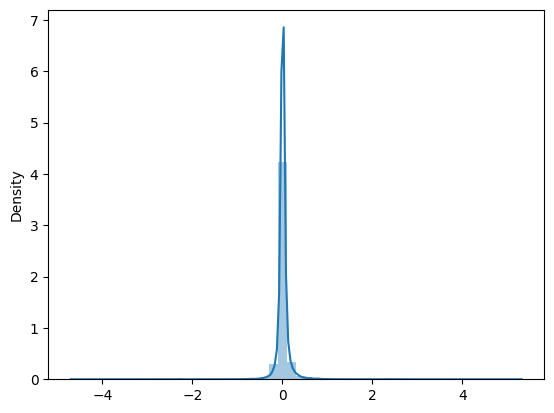

[Row(skewness(logerror)=2.8889121904501907)]


In [ ]:
# Vẽ biểu đồ phân phối của logerror
sample_df = df.select(['logerror']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()
from pyspark.sql.functions import skewness

print(df.agg({'logerror': 'skewness'}).collect())

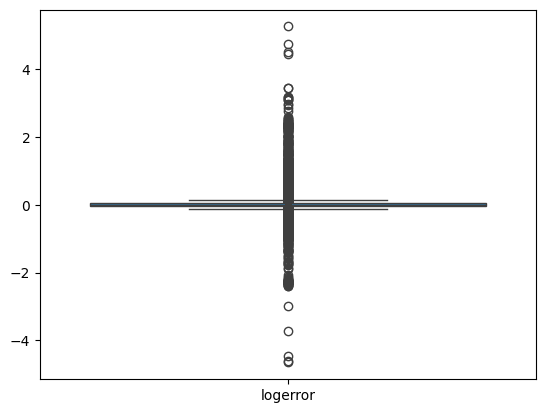

In [ ]:
# Vẽ biểu đồ Boxplot của logerror
sns.boxplot(pandas_df)
plt.show()

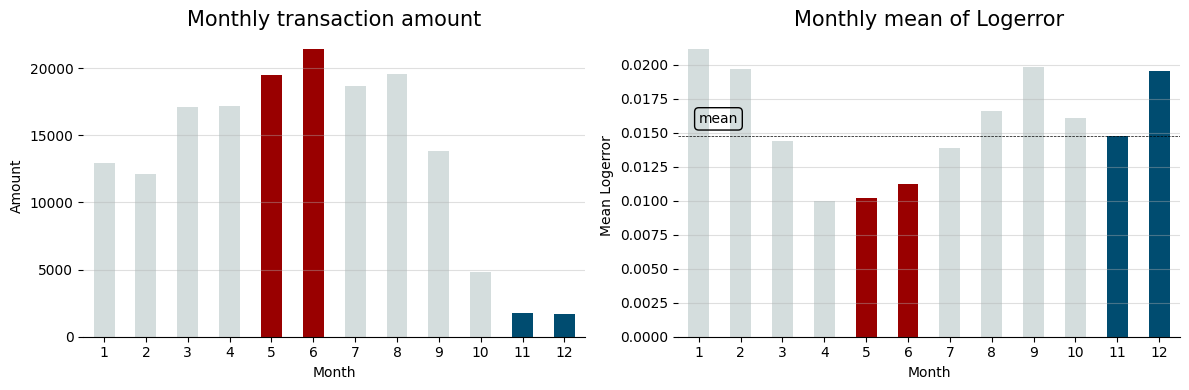

In [ ]:
df1 = df.select('month', 'logerror').toPandas()

# Thiết lập color_map
color_map = ['#d4dddd' for _ in range(12)]
color_map[10] = color_map[11] = '#004c70'
color_map[4] = color_map[5] = '#990000'

# Tạo figure và các subplot
plt.figure(figsize=(12, 4))

# Biểu đồ số lượng giao dịch theo tháng
ax1 = plt.subplot(1, 2, 1)
df1.groupby('month')['logerror'].count().plot.bar(color=color_map, ax=ax1)
plt.xticks(rotation=0)
plt.xlabel('Month')
plt.ylabel('Amount')
plt.title('Monthly transaction amount', fontsize=15)

# Tùy chỉnh các đường viền của biểu đồ
for s in ["top", "right", "left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

# Biểu đồ trung bình logerror theo tháng
ax2 = plt.subplot(1, 2, 2)
df1.groupby('month')['logerror'].mean().plot.bar(color=color_map, ax=ax2)

# Đường ngang tại giá trị trung bình logerror của toàn bộ dữ liệu
plt.axhline(df1['logerror'].mean(), linestyle='--', color='black', linewidth=0.5)
plt.text(0, df1['logerror'].mean() + 0.001, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

plt.xticks(rotation=0)
plt.xlabel('Month')
plt.ylabel('Mean Logerror')
plt.title('Monthly mean of Logerror', fontsize=15)

# Tùy chỉnh các đường viền của biểu đồ
for s in ["top", "right", "left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

## Feature Engineering

In [ ]:
# Tạo thêm cột tuổi của ngôi nhà
df = df.withColumn('house_age', F.year(col('transactiondate')) - col('yearbuilt'))

In [ ]:
# Tạo cột mới là total_room bằng  tổng số phòng ngủ và số phòng tắm
df = df.withColumn('total_room', df['bathroomcnt'] + df['bedroomcnt'])

In [ ]:
# Tính diện tích sân vườn (phần sân không được xây) bằng cách lấy diện tích lô đất - trừ đi phần diện tích hoàn thiện tính toán
df = df.withColumn('garden', df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'])

In [ ]:
# Tạo cột living_area_ratio là tỷ lệ diện tích sống so với diện tích lô đất
df = df.withColumn('living_area_ratio', df['calculatedfinishedsquarefeet'] / df['lotsizesquarefeet'])

## Outliers

In [ ]:
percentile_005 = df.approxQuantile("logerror", [0.005], 0.0)[0]  # Ngưỡng 0.5% thấp nhất
percentile_995 = df.approxQuantile("logerror", [0.995], 0.0)[0]  # Ngưỡng 99.5% cao nhất

# Lọc dữ liệu để chỉ giữ lại các giá trị logerror nằm trong khoảng [0.5%, 99.5%]
df_filtered = df.filter((F.col("logerror") >= percentile_005) & (F.col("logerror") <= percentile_995))

# Kiểm tra số lượng hàng trước và sau khi loại bỏ giá trị ngoại lai
print(f"Số lượng hàng trước khi xóa ngoại lai: {df.count()}")
print(f"Số lượng hàng sau khi xóa ngoại lai: {df_filtered.count()}")

Số lượng hàng trước khi xóa ngoại lai: 160634
Số lượng hàng sau khi xóa ngoại lai: 159029


### Correlation

In [ ]:
# Lấy ra các cột có định dạng số
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double']]

In [ ]:
# Tạo một vector với đầu vào là list các cột có định dạng số
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="cor_features")
df_vec = assembler.transform(df)

In [ ]:
# Tính hệ số tương quan giữa các cột với logerror
correlations = []
for col in numeric_cols:
    correlation = df_vec.stat.corr("logerror", col)
    correlations.append((col, abs(correlation)))

In [ ]:
df_vector = assembler.transform(df).select("cor_features")

# Tính ma trận tương quan
matrix = Correlation.corr(df_vector, "cor_features").collect()[0][0]
corr_matrix = matrix.toArray()

In [ ]:
corr_df = pd.DataFrame(data=corr_matrix, columns=numeric_cols, index=numeric_cols)

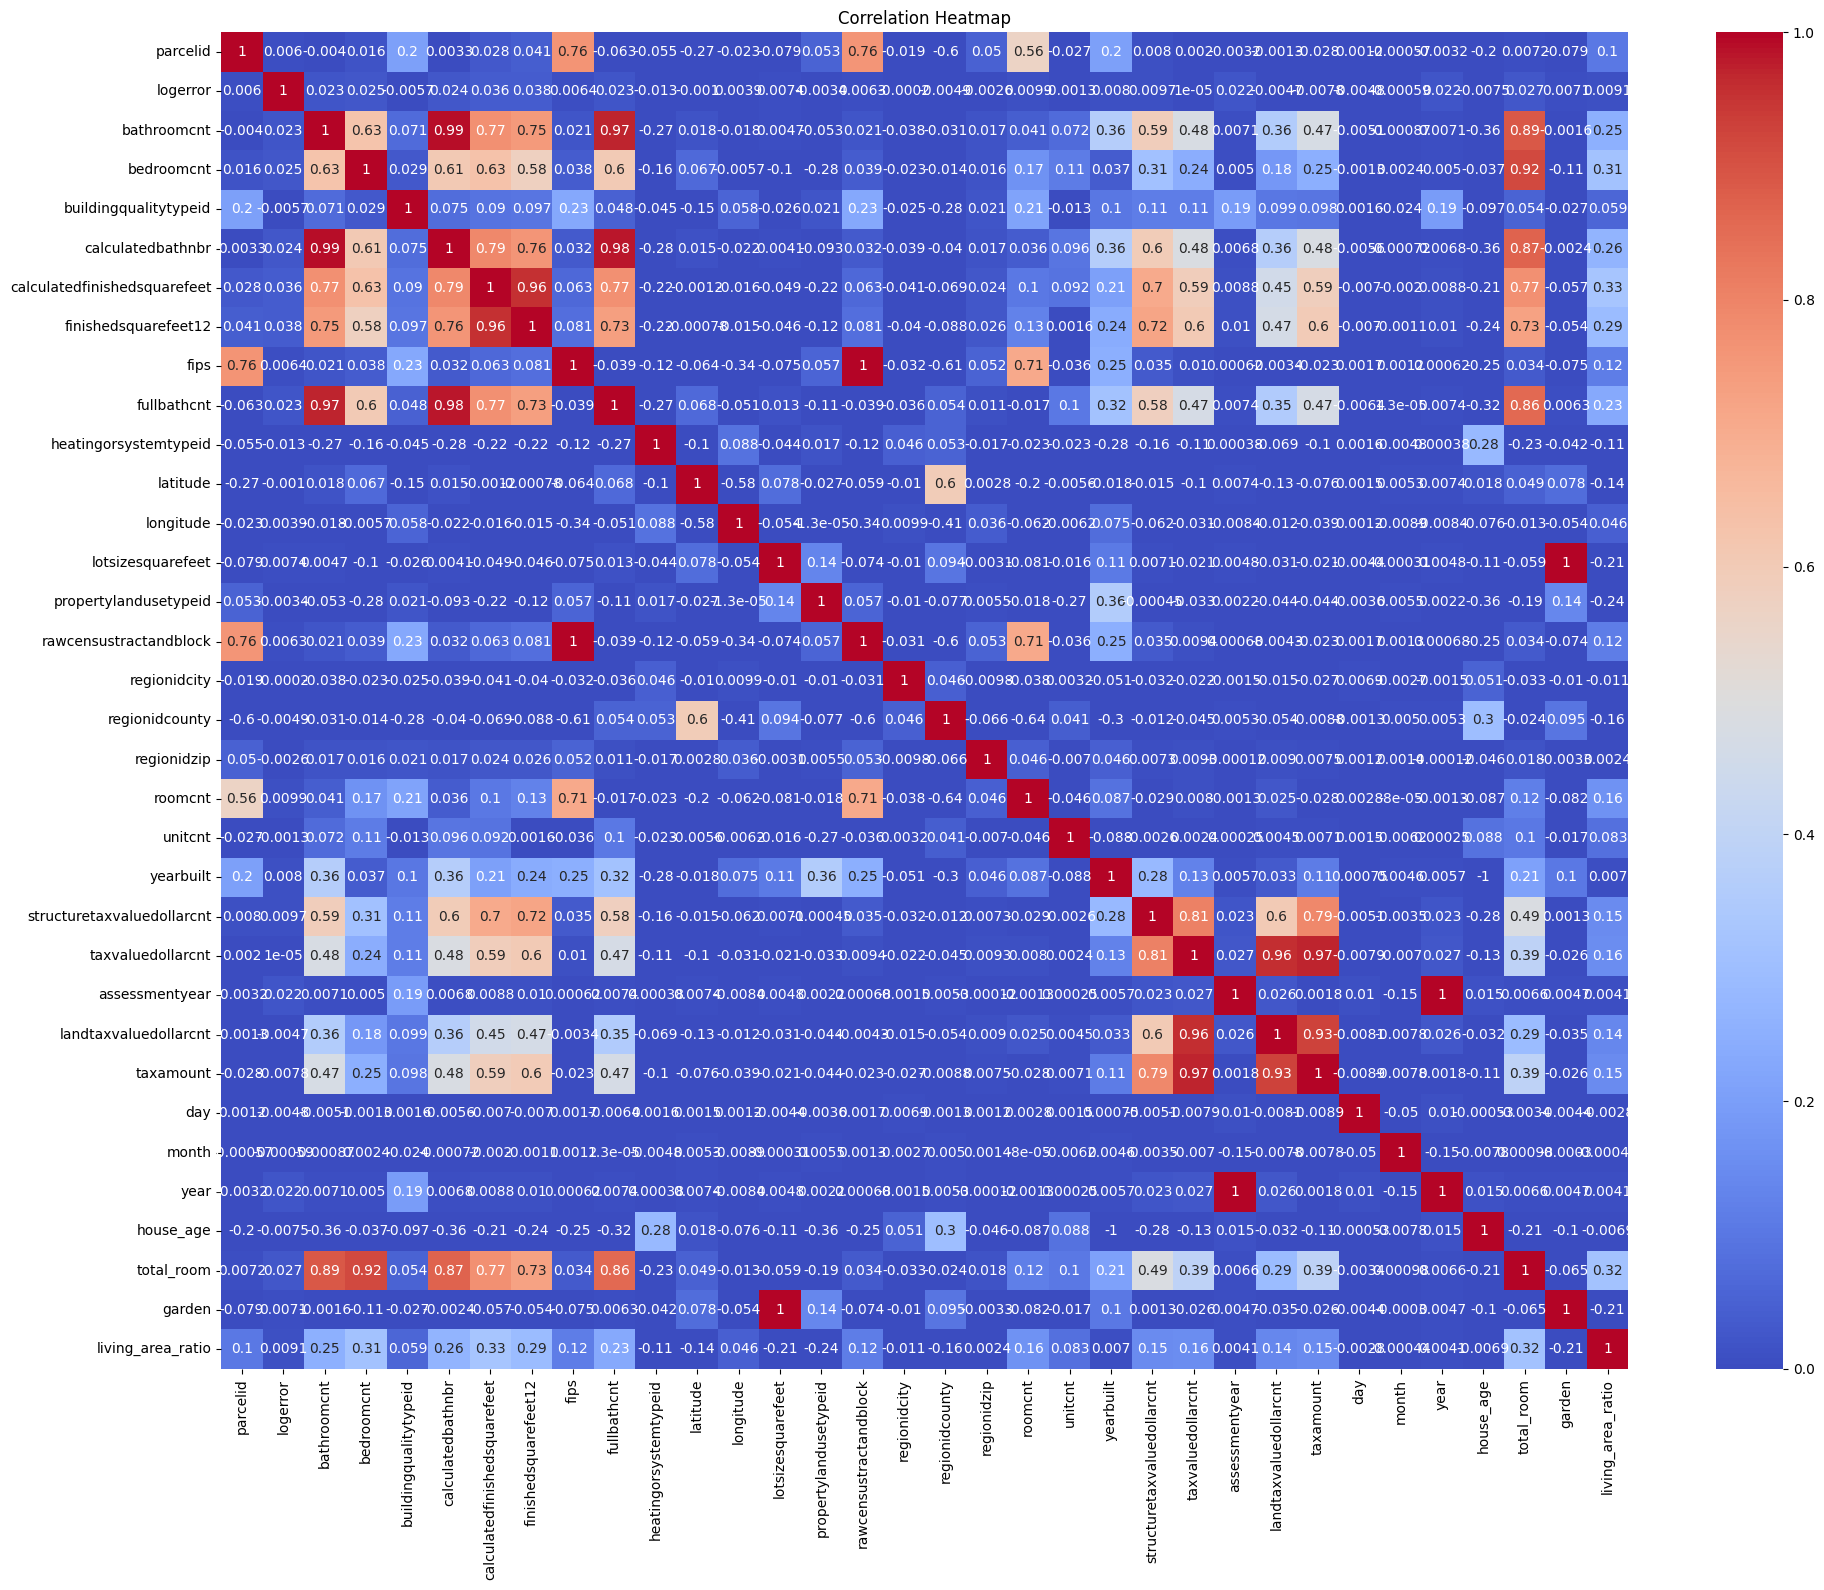

In [ ]:
# Vẽ Heatmap cho hệ số tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=0, vmax=1, center=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Vectorize feature columns


In [ ]:
features_cols=[
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'finishedsquarefeet12',
 'heatingorsystemtypeid',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'censustractandblock',
 'house_age',
 'total_room',
 'garden',
 'living_area_ratio'
 ]
vec = VectorAssembler(inputCols=features_cols, outputCol='features1')

In [ ]:
df_filtered = vec.transform(df_filtered)

In [ ]:
df_ml = df_filtered.select(['logerror', 'features1'])

## Building a Regression Model

In [ ]:
# Phân chia tập dữ liệu
trainDF, testDF = df_ml.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LinearRegression(featuresCol="features1", labelCol="logerror")

In [ ]:
model=lr.fit(trainDF)

In [ ]:
predictions = model.transform(testDF)

In [ ]:
# Bước 4: Thiết lập Grid Search cho các tham số
paramGrid = ParamGridBuilder() \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Bước 5: Thiết lập CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="logerror", metricName="rmse"),
                          numFolds=5)  # Cross-validation với 5 folds

# Bước 6: Huấn luyện mô hình
cv_model = crossval.fit(trainDF)

# Bước 7: Tìm mô hình tốt nhất
best_model = cv_model.bestModel

# In ra các tham số tốt nhất
print(f"Best Fit Intercept: {best_model._java_obj.getFitIntercept()}")
print(f"Best Reg Param: {best_model._java_obj.getRegParam()}")
print(f"Best Elastic Net Param: {best_model._java_obj.getElasticNetParam()}")

# Bước 8: Dự đoán trên tập kiểm tra
predictions = best_model.transform(testDF)

# Bước 9: Đánh giá mô hình
evaluator = RegressionEvaluator(labelCol="logerror", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Hiển thị một số dự đoán
predictions.select("prediction", "logerror").show(10)

Best Fit Intercept: True
Best Reg Param: 0.001
Best Elastic Net Param: 0.5
Root Mean Squared Error (RMSE) on test data = 0.09594151499549203
+--------------------+---------------+
|          prediction|       logerror|
+--------------------+---------------+
|0.021142768821962754|        -0.4684|
|0.027714109779735097|        -0.4636|
|0.017991243714403637|-0.462737920269|
|0.017997472791378755|-0.460394280914|
| 0.01563342455218031|-0.457340974694|
|0.006621025362325561|        -0.4557|
|0.046422968863327085|-0.450134855709|
|0.013789193959805601|-0.446788380226|
|0.005403320985418958|         -0.437|
|0.012479172288022866|         -0.437|
+--------------------+---------------+
only showing top 10 rows



In [ ]:
evaluator = RegressionEvaluator(labelCol="logerror", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f" Sai số trung bình tuyệt đối  = {mae}")

predictions.select("prediction", "logerror").show(6)

 Sai số trung bình tuyệt đối  = 0.05662961045802389
+--------------------+---------------+
|          prediction|       logerror|
+--------------------+---------------+
|0.021142768821962754|        -0.4684|
|0.027714109779735097|        -0.4636|
|0.017991243714403637|-0.462737920269|
|0.017997472791378755|-0.460394280914|
| 0.01563342455218031|-0.457340974694|
|0.006621025362325561|        -0.4557|
+--------------------+---------------+
only showing top 6 rows

